# <h1><center><b>Machine Learning</b></center></h1>
<h3><center>Exercise 5</center></h3>

Your Name:  
<font color='red'>
Eliya Rabia, 318771052
</font>


____________

**Instructions:**
- Create a copy of this notebook and implement your code in it.
- Ensure you don't leave any cells or answers empty.
- Do not change the code we provided.
- After completing the assignment, download this **notebook** (with your code and all outputs!) named ***Ex5_Machine_Learning.ipynb***, and ***predictions.txt*** file, and submit them together in a zip file named ***ex5.zip*** to the [**"submit"**](https://submit.cs.biu.ac.il/cgi-bin/welcome.cgi) system under course number **"89-2511"**, group number **"01"** and assignment **"ex5_ML"**.
To Download the notebook go to **"File"** -> **"Download .ipynb"**.  
- Submit deadline: 19/07/2024 16:00

## Part 1 - Neural Network using NumPy **(37 points)**

In this part, we learn to:
1. Load and preprocess datasets.
2. Implement and train a neural network (multi-layer perceptron) for handwriting recognition using the MNIST dataset, with *numpy* as the only library (The use of libraries other than *numpy* and *fetch_openml* function is strictly prohibited in **Part 1** only).

### **Import useful packages**

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml

### **Dataset (6 points)**


The **MNIST (Modified National Institute of Standards and Technology database)** dataset contains a training set of 60,000 images and a test set of 10,000 images of handwritten digits (10 digits). The handwritten digit images have been size-normalized and centered in a fixed size of 28x28 pixels.


image.png

Download the MNIST dataset

In [ ]:
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False, parser='auto')
print(X.shape, y.shape)

(70000, 784) (70000,)


Data normalization

In [ ]:
def min_max_norm(X):
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)

    # Avoid division by zero
    X_range = X_max - X_min
    X_range[X_range == 0] = 1  # Set range to 1 for features with zero range

    normalized_X = (X - X_min) / X_range
    return normalized_X

# Normalize the dataset
X = min_max_norm(X)

Split the data into Train set (80%) and a Test set (20%)

In [ ]:
# Split the data into Train set (80%) and Test set (20%)
def train_test_split(X, y, test_size=0.2):
    # Calculate the split index
    split_index = int(X.shape[0] * (1 - test_size))

    # Split the data
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_train, X_test, y_train, y_test

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(56000, 784) (14000, 784) (56000,) (14000,)


### **Useful functions (7 points)**

Activation function - Sigmoid

In [ ]:
## TODO: Implement the sigmoid activation function and its derivative
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

Softmax function

In [ ]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Subtract max for numerical stability
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

Loss function

In [ ]:
# Negative Log Likelihood loss function for multiclass
def nll_loss(y_pred, y_true):
    loss = -np.sum(y_true * np.log(y_pred ), dtype=np.float64)
    return loss / y_pred.shape[1]

### **Multilayer Perceptron (24 points)**

Hyper-Parameters

In [ ]:
## TODO: Define the hyper-parameters that you will need for your model
# Note that the MNIST dataset has 10 classes.
# input_layer = ... # 28X28 = 784
# hidden_layer = ...
# output_layer = ...
# learning_rate = ...
# epochs = ...

# Your code here
# Hyper-Parameters
input_layer = 784         # 28x28 pixels
hidden_layer = 64        # Number of hidden neurons (you can adjust this)
output_layer = 10         # 10 classes (digits 0-9)
learning_rate = 0.01      # Learning rate for gradient descent
epochs = 10               # Number of training epochs

Multilayer Perceptron class with train and test functions.

In [ ]:
class MultilayerPerceptron:
    def __init__(self, input_layer, hidden_layer, output_layer, learning_rate, epochs):
        # Initialize the parameters using He initialization
        self.W1 = np.random.randn(input_layer, hidden_layer) * np.sqrt(2. / input_layer)
        self.b1 = np.zeros((hidden_layer, 1))
        self.W2 = np.random.randn(hidden_layer, output_layer) * np.sqrt(2. / hidden_layer)
        self.b2 = np.zeros((output_layer, 1))

        # Hyperparameters
        self.learning_rate = learning_rate
        self.epochs = epochs

    def forward(self, X):
        # Implement the forward pass
        Z1 = np.dot(self.W1.T, X) + self.b1
        A1 = sigmoid(Z1)
        Z2 = np.dot(self.W2.T, A1) + self.b2
        A2 = softmax(Z2)
        return Z1, A1, Z2, A2

    def backward(self, X, Y, Z1, A1, Z2, A2):
        # Implement the backward pass, Back propagation - compute the gradients of each parameter
        m = X.shape[1]

        dZ2 = A2 - Y
        dW2 = np.dot(A1, dZ2.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m

        dA1 = np.dot(self.W2, dZ2)
        dZ1 = dA1 * sigmoid_derivative(Z1)
        dW1 = np.dot(X, dZ1.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        # Gradient descent parameter update
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X_train, y_train):
        train_size = len(X_train)

        for epoch in range(self.epochs):
            total_epoch_loss = 0
            for i in range(train_size):

                # Reshape image i to be (784x1)
                x_i = X_train[i].reshape(-1, 1)
                Z1, A1, Z2, A2 = self.forward(x_i)

                # Define y_true as a zero vector with the shape (10, 1)
                y_true = np.zeros((10, 1))
                y_true[int(y_train[i])] = 1

                loss = nll_loss(A2, y_true)
                total_epoch_loss += loss
                self.backward(x_i, y_true, Z1, A1, Z2, A2)
            print(f"Epoch {epoch+1}/{self.epochs}, Average Loss: {total_epoch_loss/train_size}")

    def test(self, X_test, y_test):
        true_predictions = 0
        test_size = X_test.shape[0]

        for i in range(test_size):
            x_i = X_test[i].reshape(-1, 1)
            _, _, _, A2 = self.forward(x_i)
            prediction = np.argmax(A2, axis=0)
            if prediction == int(y_test[i]):
                true_predictions += 1

        accuracy = true_predictions / test_size
        print(f"Accuracy: {accuracy:.2f}")

#### **Train**

In [ ]:
# TODO: Define your mlp model with all the parameters
mlp = MultilayerPerceptron(input_layer=input_layer, hidden_layer=hidden_layer, output_layer=output_layer, learning_rate=learning_rate, epochs=epochs)

# Train your model
mlp.train(X_train, y_train)

Epoch 1/10, Average Loss: 0.37933081769260923
Epoch 2/10, Average Loss: 0.20973180512861106
Epoch 3/10, Average Loss: 0.16052933120778942
Epoch 4/10, Average Loss: 0.13066998704647229
Epoch 5/10, Average Loss: 0.11061935198334817
Epoch 6/10, Average Loss: 0.09619921808992374
Epoch 7/10, Average Loss: 0.08521925818159742
Epoch 8/10, Average Loss: 0.07646107487039708
Epoch 9/10, Average Loss: 0.06921430513665071
Epoch 10/10, Average Loss: 0.06305663286908723


#### **Test**

Accuracy should be more than **0.8** !

In [ ]:
mlp.test(X_test, y_test)

Accuracy: 0.97


## Part 2 - Neural Network in PyTorch **(63 points)**

____________

In this exercise, we will learn to:
1. Load and preprocess datasets using Pytorch.
2. Implement and train a neural network (multi-layer perceptron) for Fashion classification (Fashion-MNIST dataset), using Pytorch.
3. Implement and train a Convolutional Neural Network (CNN) on Fashion-MNIST.

### **1. Setup**
Before running code on Colab:
- Navigate to "Runtime" -> "Change runtime type", and ensure you select "GPU" for Hardware accelerator.
- Verify your Python version at the command line by executing '!python --version'. It should default to Python 3.6 or higher.
- Upload the **[FashionMNIST_test.pth](https://drive.google.com/file/d/1FeOaoRU-tkhOiKzsK_UZNwbNPaRqaDVu/view?usp=sharing)** file to your Drive (e.g "machine_learning/assignments/assignment5") and mount that data to the machine. See the next cell below. Although it is possible to upload files to the local disk of Colab machines, note that such files will be deleted when the machine is restarted.

In [ ]:
# check python version
!python --version

Python 3.10.12


In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the code and datasets.
# Recommended path: 'machine_learning/assignments/assignment5/'
FOLDERNAME = 'machine_learning/assignments/'
ASSIGNMENTNAME = 'assignment5'

%cd drive/My\ Drive
%cp -r $FOLDERNAME/$ASSIGNMENTNAME ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


### **2. Dataset (4 points)**

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes - **'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'**.

image.png

Let's visualize the data before working with it.  
1. We can use the "torchvision" package to download the trainset. Set ```transform``` as to be the transform function below (It normalizes each image) and ```train=True```.
2. We use torch.utils.data.DataLoader to load the data. Set ```batch_size=64```.

In [3]:
# load packages
import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt

In [4]:
data_path = "./FashionMNIST_data"

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the data
mnist_data = datasets.FashionMNIST(data_path, download=True, train=True, transform=transform)
mnist_dataloader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:03<00:00, 8121439.04it/s] 


Extracting ./FashionMNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 198507.58it/s]


Extracting ./FashionMNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3658147.87it/s]


Extracting ./FashionMNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15534012.22it/s]

Extracting ./FashionMNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST_data/FashionMNIST/raw



Using the ```mnist_data``` (dataset) and ```mnist_dataloader``` (batch dataloader):
1. Print the number of samples in the whole dataset.
2. Print the number of samples in a single batch.
3. Print the shape of images in the data.
4. Print the number of labels in the dataset (targets).
5. Plot 3 random images using matplotlib (```plt.imshow```) and print their labels.

In [5]:
# get single batch
dataiter = iter(mnist_dataloader)
batch_images, batch_labels = next(dataiter)

# TODO: 1. Print the number of samples in the whole dataset.
print(f"Number of samples in the whole dataset: {len(mnist_data)}")

# TODO: 2. Print the number of samples in a single batch.
print(f"Number of samples in a single batch: {batch_images.shape[0]}")

# TODO: 3. Print the shape of images in the data (image dimensions).
print(f"Shape of images in the data: {batch_images.shape[1:]}")

# TODO: 4. Print the number of labels in the whole dataset (using the targets in the dataloader.dataset).
print(f"Number of labels in the whole dataset: {len(mnist_data.targets)}")


Number of samples in the whole dataset: 60000
Number of samples in a single batch: 64
Shape of images in the data: torch.Size([1, 28, 28])
Number of labels in the whole dataset: 60000


Labels: ['Sneaker', 'T-shirt/top', 'Coat']


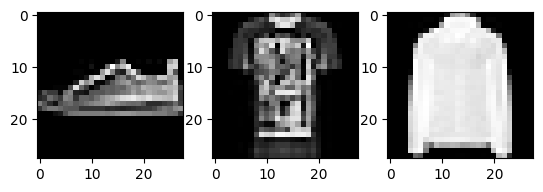

In [6]:
# 5. plot three images and print their labels
idx = np.random.choice(range(64),3) # three random indices
plt.subplot(1,3,1)
plt.imshow(batch_images[idx[0]].numpy().squeeze(), cmap='Greys_r')
plt.subplot(1,3,2)
plt.imshow(batch_images[idx[1]].numpy().squeeze(), cmap='Greys_r')
plt.subplot(1,3,3)
plt.imshow(batch_images[idx[2]].numpy().squeeze(), cmap='Greys_r')

# Define the label names array, where each label corresponds to its class, which is also its index
label_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

print("Labels:", [label_names[i] for i in batch_labels[idx]])

### **3. Neural Network - Architecture (11 points)**

In the next section, we are going to implement a neural network with pytorch that gets Fashion-MNIST images and recognizes the digit in them.  

Network Architecture (see image below): **784 input units**, a hidden layer with **128 units** and a **ReLU activation**, then a hidden layer with **64 units** and a **ReLU activation**, and finally an **output layer** with a **log-softmax activation**.

Note: Since simple neural networks get vectors as inputs, and not images (unlike CNNs), we should flatten the data. Each sample with shape (28,28) becomes (784,). That is why the input layer has 784 units.  


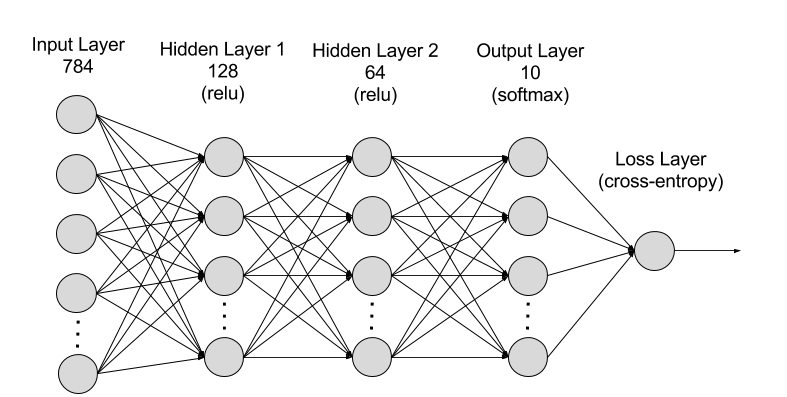

Complete the code below: The constructor (```__init___```) should contain defenitions of layers like ```Linear``` or ```Relu```. The ```forward``` function should contain the logic between the layers declared in the constructor.  

For this section, as well as the next section, you can follow online tutorials (like **[this tutorial](https://adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/)** or **[this one](https://www.marktechpost.com/2019/11/09/create-a-neural-network-with-pytorch/)**) to understand how to implement Neural Networks with Pytorch.

In [7]:
from torch import nn, optim
import torch.nn.functional as F

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        '''
        Declare layers for the model
        '''
        super().__init__()
        # TODO
        self.fc1 = nn.Linear(28 * 28, 128)  # Input layer to hidden layer 1
        self.fc2 = nn.Linear(128, 64)       # Hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(64, 10)        # Hidden layer 2 to output layer

        # Initialize weights
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
        ''' Forward pass through the network, returns log_softmax values '''
        x = x.view(-1, 28 * 28)  # Flatten the input tensor
        x = F.relu(self.fc1(x))  # Pass through the first hidden layer and apply ReLU activation
        x = F.relu(self.fc2(x))  # Pass through the second hidden layer and apply ReLU activation
        x = F.log_softmax(self.fc3(x), dim=1)  # Pass through the output layer and apply log-softmax activation
        return x

model = NeuralNetwork()
model

NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Now that we have a network, let's see what happens when we pass in an image.  
We'll choose a random image and pass it through the network. It should return a prediction - confidences for each class. The class with the highest confidence is the prediction of the model for that image.   
We visualize the results using the ```view_classify``` function below.

In [9]:
def view_classify(img, ps, version="MNIST"):
    '''
    Function for viewing an image and its predicted classes.
    img - the input image to the network
    ps - the class confidences (network output)
    '''
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')

    # Setting the y-ticks for the bar chart
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))  # Numeric y-ticks for positioning

    # Using set_yticklabels to assign string labels to y-ticks
    if version == "MNIST":
        ax2.set_yticklabels(label_names)

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()

In [10]:
def random_prediction_example(data_loader, model):
  '''
  The function sample an image from the data, pass it through the model (inference)
  and show the prediction visually. It returns the predictions confidences.
  '''
  # take a batch and randomly pick an image
  dataiter = iter(data_loader)
  images, labels = next(dataiter)
  images.resize_(64, 1, 784)
  img = images[0]

  # Forward pass through the network
  # we use torch.no_grad() for faster inference and to avoid gradients from
  # moving through the network.
  with torch.no_grad():
      ps = model(img)
      # the network outputs log-probabilities, so take exponential for probabilities
      ps = torch.exp(ps)

  # visualize image and prediction
  view_classify(img.view(1, 28, 28), ps)
  return ps

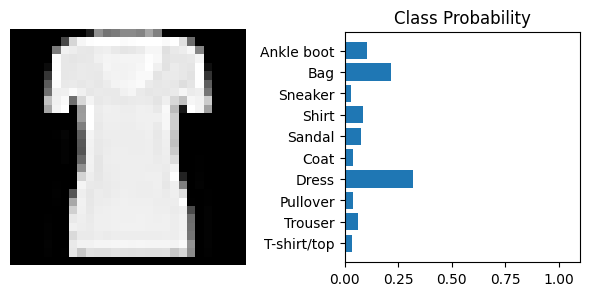

In [11]:
# you can run this cell multiple times for different images
preds_conf = random_prediction_example(mnist_dataloader, model)

`Print the prediction`

In [12]:
# TODO: Print the prediction of the network for that sample (preds_conf)
pred_class = torch.argmax(preds_conf, dim=1).item()
print(f"Predicted Class: {label_names[pred_class]}")

Predicted Class: Dress


### **4. Neural Network - Training (35 points)**

We can now train and evaluate our network.
1. Split the dataset into a training set and a validation set. Train-set size: 80% of the total data. Val-set size: the rest 20%.
2. Create a dataloader for each set (```train_loader``` and ```val_loader```, see Section 2 for examples).
3. Choose hyperparameters (for now we choose ```learning_rate=0.005``` and ```num_epochs=5```).
4. Use SGD (Stochastic Gradient Descent) as the optimizer.
5. Since it is a multi-class classification task, use "negative log-likelihood loss" as the loss criterion.
6. Train your model on the train-set and evaluate it on the validation-set.
7. During training, for each epoch, track the training loss and validation loss.

In [13]:
from torch.utils import data

In [14]:
# TODO: 1. split trainset into train and validation (use torch.utils.data.random_split())
train_size = int(0.8 * len(mnist_data))
val_size = len(mnist_data) - train_size
train_set, val_set = data.random_split(mnist_data, [train_size, val_size])

# TODO: 2.1. create data loader for the trainset (batch_size=64, shuffle=True)
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True)

# TODO: 2.2. create data loader for the valset (batch_size=64, shuffle=False)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False)

In [15]:
# 3. set hyper parameters
learning_rate = 0.005
nepochs = 5

In [16]:
model = NeuralNetwork()

# TODO: 4. create sgd optimizer. It should optimize our model parameters with
#    learning_rate defined above
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# TODO: 5. create a criterion object. It should be negative log-likelihood loss since the task
#    is a multi-task classification (digits classification)
criterion = nn.NLLLoss()

In [17]:
# 6.1. Train the model. (Fill empty code blocks)
def train_model(model, optimizer, criterion,
                nepochs, train_loader, val_loader, is_image_input = False):
  '''
  Train a pytorch model and evaluate it every epoch.
  Params:
  model - a pytorch model to train
  optimizer - an optimizer
  criterion - the criterion (loss function)
  nepochs - number of training epochs
  train_loader - dataloader for the trainset
  val_loader - dataloader for the valset
  is_image_input (default False) - If false, flatten 2d images into a 1d array.
                                Should be True for Neural Networks
                                but False for Convolutional Neural Networks.
  '''
  train_losses, val_losses = [], []
  for e in range(nepochs):
      running_loss = 0
      running_val_loss = 0
      for images, labels in train_loader:
          if is_image_input:
            # Flatten Fashion-MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

          # Training pass
          model.train() # set model in train mode

          # TODO: Compute the loss and do the backward and optimizer step
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
      else:
          val_loss = 0
          # 6.2 Evalaute model on validation at the end of each epoch.
          with torch.no_grad():
              for images, labels in val_loader:
                  if is_image_input:
                    # Flatten Fashion-MNIST images into a 784 long vector
                    images = images.view(images.shape[0], -1)
                  model.eval() # set model in evaluation mode

                  # TODO: compute the Validation Loss
                  outputs = model(images)
                  val_loss = criterion(outputs, labels)

                  running_val_loss += val_loss.item()

          # 7. track train loss and validation loss
          train_losses.append(running_loss/len(train_loader))
          val_losses.append(running_val_loss/len(val_loader))

          print("Epoch: {}/{}.. ".format(e+1, nepochs),
                "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                "Validation Loss: {:.3f}.. ".format(running_val_loss/len(val_loader)))
  return train_losses, val_losses

In [18]:
  # 6.1. Train the model.
  ## NOTE: Do not run this cell continuously without running the two cells above!
  ##       Otherwise, you might train a model you have already trained.
  ##       So make sure to run the two cells above (to first initialize the model
  ##       and optimizer), every time, before running this cell!
train_losses, val_losses = train_model(model, optimizer, criterion, nepochs,
                                       train_loader, val_loader, is_image_input=True)

Epoch: 1/5..  Training Loss: 0.806..  Validation Loss: 0.576.. 
Epoch: 2/5..  Training Loss: 0.541..  Validation Loss: 0.509.. 
Epoch: 3/5..  Training Loss: 0.490..  Validation Loss: 0.477.. 
Epoch: 4/5..  Training Loss: 0.460..  Validation Loss: 0.457.. 
Epoch: 5/5..  Training Loss: 0.439..  Validation Loss: 0.439.. 


If you implemented everything correctly, you should see the training loss drop with each epoch.

8. Plot train loss and validation loss as a function of epoch. **On the same graph!**

In [19]:
# TODO: plot train and validation loss as a function of # epochs
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

With the network trained, we can check out it's predictions:

In [20]:
# you can run this cell multiple times for different images
ps = random_prediction_example(mnist_dataloader, model)

Calculate the model's accuracy on the validation-set.

In [21]:
def evaluate_model(model, val_loader, is_image_input=False):
  '''
  Evaluate a model on the given dataloader.
  Params:
  model - a pytorch model to train
  val_loader - dataloader for the valset
  is_image_input (default False) - If false, flatten 2d images into a 1d array.
                                   Should be True for Neural Networks
                                   but False for Convolutional Neural Networks.
  '''
  validation_accuracy = 0
  with torch.no_grad():
      model.eval()
      for images, labels in val_loader:
          if is_image_input:
            # flatten Fashion-MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
          # forward pass
          test_output = model(images)
          ps = torch.exp(test_output)
          top_p, top_class = ps.topk(1, dim=1)
          # count correct predictions
          equals = top_class == labels.view(*top_class.shape)
          validation_accuracy += torch.sum(equals.type(torch.FloatTensor))
  res = validation_accuracy/len(val_loader.dataset)
  return res

In [22]:
print(f"Validation accuracy: {evaluate_model(model, val_loader, is_image_input=True)}")

Validation accuracy: 0.843916654586792


### **5. Convolutional Neural Networks (13 points)**

In this section, we are going to implement a convolutional neural network (CNN) and train it on the mnist dataset. It will be very similar to what you did in the previous sections but now we use new layers like ```convolution```and ```pooling```.  

image.png

Reminder:  
Go over this **[article](https://cs231n.github.io/convolutional-networks/)** to better understand convolutional neural networks.

- **Convolutional operation:** A “filter”, also called a “kernel”, is passed over the image, viewing a few pixels at a time (for example, 3X3 or 5X5). The convolution operation is a dot product of the original pixel values with weights defined in the filter. The results are summed up into one number that represents all the pixels the filter observed.

- **Pooling:** “Pooling” is the process of further downsampling and reducing the size of the matrix. A filter is passed over the results of the previous layer and selects one number out of each group of values (typically the maximum, this is called max pooling). This allows the network to train much faster, focusing on the most important information in each feature of the image. By sliding the window along the image, we compute the mean or the max of the portion of the image inside the window in case of MeanPooling or MaxPooling.

- **Stride:** The number of pixels to pass at a time when sliding the convolutional kernel.

- **Padding:** To preserve exactly the size of the input image, it is useful to add zero padding on the border of the image.

**How do we compute the output size of a convolutional layer?**

input:
- An image of dimensions $W_{in}×H_{in}$.
- A filter of dimensions $K \times K$.
- Stride $S$
- padding $P$

$$W_{out} = \left\lfloor\frac{W_{in} - F + 2P}{S}\right\rfloor + 1$$
<br>
$$H_{out} = \left\lfloor\frac{H_{in} - F + 2P}{S}\right\rfloor + 1$$

**Q1:** Given an image with shape [1,28,28], what will be the shape of the output of a convolution layer with 10 5x5 kernels (filters), with stride of 1, and without padding?

**A1:**
<font color='red'>
To calculate the output size of a convolutional layer, we can use the following formulas.
by the follwing Q1 information: W in =H in = 28, F=5, S=1, p=0
now we have all the inforamtion to calculate the formulas above and the resulat will be W out =24 = H out and because there are 10 filters.
thus, output shape = [10,24,24]
</font>

**Q2:** We would like our convolution layer to output a volume with the same shape as the input image. So input_shape and output_shape will be [1,28,28]. What should be the padding (assume 5x5 filter and stride of 1)?

**A2:**
<font color='red'>
To ensure that the output of the convolutional layer has the same spatial dimensions as the input, we need to use padding. The padding can be calculated using the formulas above.
by the provided information, H in = W in = 28, F=5,S=1 after put this in the furmulas we will get p=2.
so the resulat is p=2.
</font>

**Q3:** Consider an input image with shape [1, 28, 28]. You apply two consecutive convolution layers. The first convolution layer uses 20 filters, each of size 3x3, with a stride of 1 and no padding. The second convolution layer uses 15 filters, each of size 3x3, with a stride of 3 and padding of 2. What will be the shape of the output after these two convolution layers?

**A3:**
<font color='red'>
for the first the provided information is:F=3,S=1,P=0,H in=W in =28.
put this on the fornulas above and we will get H out = W out = 26 and we have 20 filters so the resulat in the first time will be [20,26,26].
then for the second, F=3,S=3,P=2, H in = W in = 26.
put this on the fornulas above and we will get H out = W out = 10 and we have 15 filters so the resulat in the second time will be [15,10,10].
so the final resulat is [15,10,10].
</font>

Let's create a simple Convolutional neural network.
The architecture:  
**Conv layer** (10 5x5 Kernels) -> **Max Pooling** (2x2 kernel) -> **Relu** -> **Conv layer** (20 5x5 Kernels) -> **Max Pooling** (2x2 kernel) -> **Relu** -> **Hidden layer** (320 units) -> **Relu** -> **Hidden layer** (50 units) -> **Output layer** (10 outputs).

In [23]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x) # conv 1
        x = F.max_pool2d(x, 2) # max pooling 1
        x = F.relu(x) # relu
        x = self.conv2(x) # conv 2
        x = F.max_pool2d((x), 2) # max pooling 2
        x = F.relu(x) # relu
        x = x.view(-1, 320) # flatten input
        x = self.fc1(x) # hidden layer 1
        x = F.relu(x) # relu
        x = self.fc2(x) # hidden layer 2
        return F.log_softmax(x, dim=1) #output

cnn_model = ConvolutionalNet()
print(cnn_model)

ConvolutionalNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


We can now train the model on the train set.

In [24]:
# set hyperparameters
cnn_nepochs = 3
cnn_learning_rate = 0.03

In [25]:
# train the conv model
cnn_model = ConvolutionalNet()
# create sgd optimizer
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=cnn_learning_rate)
# create negative log likelihood loos
cnn_criterion = nn.NLLLoss()

train_losses, val_losses = train_model(cnn_model, cnn_optimizer, cnn_criterion,
                                       cnn_nepochs, train_loader, val_loader, is_image_input=False)

Epoch: 1/3..  Training Loss: 0.913..  Validation Loss: 0.576.. 
Epoch: 2/3..  Training Loss: 0.530..  Validation Loss: 0.466.. 
Epoch: 3/3..  Training Loss: 0.444..  Validation Loss: 0.402.. 


In [26]:
# evaluate on the validation set
print(f"Validation accuracy: {evaluate_model(cnn_model, val_loader, is_image_input=False)}")

Validation accuracy: 0.8536666631698608


You should probably see that our CNN performs better on the validation set compared to the simple neural network (within 3 epochs only!) :)

___________

Now it's your turn: Use the code above and create a convolutional neural network that achieves the best accuracy on the validation set.
Note that you must use only the Fashion-MNIST training set as we did earlier:
```mnist_data = datasets.FashionMNIST(data_path, download=True, train=True, transform=transform)```

**Using any other or additional data from the test set will result in point deductions (without any bonus)!**

You should consider changing (change at least 4 things):  
1. Network architecture:
  - Number of convolutional layers
  - Number of kernels (filters) for each convolutional layer
  - Size of each kernel on each layer
  - Number of hidden layers (fully connected)
  - Number of units for each hidden layer
  - Usage of layers like BatchNormalization and Dropout.
  - Usage of max pooling (or maybe other pooling strategies)

2. Training hyperparameters:
  - Learning rate
  - Optimizer (SGD with momentum, adam, etc)
  - Number of epochs

To get full points in this part: make sure you implement the model architecture correctly, train the model properly, use the optimizer effectively, and ensure your validation accuracy is greater than 80%. **(4 points for this part)**

In [32]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

data_path = "./FashionMNIST_data_CNN"

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ])

# Download and load the data
mnist_data = datasets.FashionMNIST(data_path, download=True, train=True, transform=transform)
mnist_dataloader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(mnist_data))
val_size = len(mnist_data) - train_size
train_data, val_data = random_split(mnist_data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


In [33]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm_fc1 = nn.BatchNorm1d(256)
        self.batchnorm_fc2 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.batchnorm_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batchnorm_fc2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

cnn_model = ConvolutionalNet()

# Hyperparameters
cnn_nepochs = 15
cnn_learning_rate = 0.001

# Optimizer and loss function
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=cnn_learning_rate)
cnn_criterion = nn.NLLLoss()

# Training function
def train_model(model, optimizer, criterion, nepochs, train_loader, val_loader, is_image_input=False):
    train_losses, val_losses = [], []
    for e in range(nepochs):
        running_loss = 0
        running_val_loss = 0
        for images, labels in train_loader:
            if is_image_input:
                images = images.view(images.shape[0], -1)

            model.train()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        else:
            val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    if is_image_input:
                        images = images.view(images.shape[0], -1)
                    model.eval()
                    outputs = model(images)
                    val_loss = criterion(outputs, labels)
                    running_val_loss += val_loss.item()

            train_losses.append(running_loss/len(train_loader))
            val_losses.append(running_val_loss/len(val_loader))

            print("Epoch: {}/{}.. ".format(e+1, nepochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                  "Validation Loss: {:.3f}.. ".format(running_val_loss/len(val_loader)))

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(cnn_model, cnn_optimizer, cnn_criterion,
                                       cnn_nepochs, train_loader, val_loader, is_image_input=False)


Epoch: 1/15..  Training Loss: 0.567..  Validation Loss: 0.353.. 
Epoch: 2/15..  Training Loss: 0.383..  Validation Loss: 0.324.. 
Epoch: 3/15..  Training Loss: 0.343..  Validation Loss: 0.291.. 
Epoch: 4/15..  Training Loss: 0.318..  Validation Loss: 0.263.. 
Epoch: 5/15..  Training Loss: 0.294..  Validation Loss: 0.262.. 
Epoch: 6/15..  Training Loss: 0.288..  Validation Loss: 0.244.. 
Epoch: 7/15..  Training Loss: 0.271..  Validation Loss: 0.248.. 
Epoch: 8/15..  Training Loss: 0.269..  Validation Loss: 0.242.. 
Epoch: 9/15..  Training Loss: 0.257..  Validation Loss: 0.243.. 
Epoch: 10/15..  Training Loss: 0.247..  Validation Loss: 0.235.. 
Epoch: 11/15..  Training Loss: 0.240..  Validation Loss: 0.225.. 
Epoch: 12/15..  Training Loss: 0.237..  Validation Loss: 0.228.. 
Epoch: 13/15..  Training Loss: 0.230..  Validation Loss: 0.219.. 
Epoch: 14/15..  Training Loss: 0.224..  Validation Loss: 0.231.. 
Epoch: 15/15..  Training Loss: 0.219..  Validation Loss: 0.222.. 


In [34]:
# TODO: Save the best model in this variable and evaluate on the validation set
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

validation_accuracy = evaluate_model(cnn_model, val_loader)

# Save the Best Model
best_model = cnn_model
torch.save(best_model.state_dict(), 'best_model.pth')
print(f"Validation accuracy: {evaluate_model(best_model, val_loader)}%")

Validation accuracy: 92.16666666666667%


When you are satisfied with your model performance on the validation set, load the test set given to you (**important** - apply any transformation you applied to the train set before) - [FashionMNIST_test.pth](https://drive.google.com/file/d/1FeOaoRU-tkhOiKzsK_UZNwbNPaRqaDVu/view?usp=sharing), into your drive assignment folder (e.g "machine_learning/assignments/assignment5/FashionMNIST_test.pth"), and write the model predictions for each test sample to a file called "predictions.txt". You can use the code below.


**Download the "predictions.txt" file to your computer, and then upload it to the "submit" system with this notebook in one zip file named ex5.zip**

Ensure each prediction is printed in a new line.

For Example ("predictions.txt"):
```
0  
5  
9
```

<font color='blue'><b>
Note: Bonus points will be given for the top 10 submissions having the highest test accuracy:
- Top 1-3 get 5 points
- Top 4-6 get 3 points
- top 7-10 get 2 points  
</b></font>  

In [35]:
def predict_and_save(model, test_path, file_name):
  # load mnist test data
  mnist_test_data = torch.utils.data.TensorDataset(torch.load(test_path))

  ## TODO: Prepocess the test set (i.e apply the transform to normalize the test set as you did to your train set)
  transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ])

  # create a dataloader
  mnist_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=32, shuffle=False)
  # make a prediction for each batch and save all predictions in total_preds
  total_preds = torch.empty(0, dtype=torch.long)
  for imgs in mnist_test_loader:
    log_ps = model(imgs[0])
    ps = torch.exp(log_ps)
    _, top_class = ps.topk(1, dim=1)
    total_preds = torch.cat((total_preds, top_class.reshape(-1)))
  total_preds = total_preds.cpu().numpy()
  # write all predictions to a file
  with open(file_name,"w") as pred_f:
    for pred in total_preds:
      pred_f.write(str(pred) + "\n")


In [36]:
predict_and_save(best_model, test_path=f"{ASSIGNMENTNAME}/FashionMNIST_test.pth", file_name="predictions.txt")